## 📚 Import Required Libraries

In this section, we import the necessary libraries to enable the required functionalities and operations for the project.

In [114]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import itertools, time, pprint, random
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, ParameterSampler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

## 🧹 Data Preprocessing  
 In this section, we perform data preprocessing to clean, transform, and prepare the dataset for analysis or modeling.

### 📥 Load Dataset  
In this subsection, we load the dataset as a pandas dataframe 🐼

In [115]:
TRAIN_PATH = "train_data.csv"
TEST_PATH  = "test_data.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print(f"Train shape: {train_df.shape}")
print(f"Test  shape: {test_df.shape}")

Train shape: (26473, 22)
Test  shape: (4467, 21)


### 🔎 Data Overview
In this subsection, we provide an overview of the dataset, including its structure, features, and key characteristics to understand the data before analysis or modeling.

In [116]:
train_df.head()

,id,Birth_Date,Weight,Height,Urban_Rural,Occupation,Insurance_Type,Family_History,Cancer_Type,Stage_at_Diagnosis,...,Tumor_Size,Surgery_Date,Chemotherapy_Drugs,Radiation_Sessions,Immunotherapy,Targeted_Therapy,Recurrence_Status,Smoking_History,Alcohol_Use,label
0,1,1994-07-01,64.9,155.0cm,Urban,Unemployed,UEBMI,No,Breast,II,...,8.0,2024-10-19,"Paclitaxel,Docetaxel,Doxorubicin",16,No,Yes,NO,Never,Regular,1
1,2,1992-07-16,61.4,171.0cm,Urban,Factory Worker,UEBMI,Yes,Breast,I,...,10.0,2021-02-28,"Cyclophosphamide,Paclitaxel,Doxorubicin,Docetaxel",10,No,No,Yes,Former,Regular,1
2,3,1948-06-23,60.7,170.0cm,Rural,Unemployed,NRCMS,No,Stomach,IV,...,13.0,2022-09-25,"Fluorouracil,Cisplatin",21,Yes,No,NO,Former,Never,0
3,4,1954-11-26,70.2,171.0cm,Urban,Farmer,URBMI,Yes,Cervical,IV,...,3.0,2024-09-13,Cisplatin,10,No,Yes,NO,Never,Regular,1
4,5,1979-07-08,100.3,186.0cm,Rural,Office Worker,Self-pay,Yes,Lung,II,...,12.0,2023-12-08,"Gemcitabine,Carboplatin",6,Yes,No,Yes,Former,Never,0


In [117]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26473 entries, 0 to 26472
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  26473 non-null  int64  
 1   Birth_Date          26473 non-null  object 
 2   Weight              26473 non-null  float64
 3   Height              26473 non-null  object 
 4   Urban_Rural         26473 non-null  object 
 5   Occupation          26473 non-null  object 
 6   Insurance_Type      26473 non-null  object 
 7   Family_History      26473 non-null  object 
 8   Cancer_Type         26473 non-null  object 
 9   Stage_at_Diagnosis  26473 non-null  object 
 10  Diagnosis_Date      26473 non-null  object 
 11  Symptoms            25972 non-null  object 
 12  Tumor_Size          26473 non-null  float64
 13  Surgery_Date        18898 non-null  object 
 14  Chemotherapy_Drugs  22423 non-null  object 
 15  Radiation_Sessions  26473 non-null  int64  
 16  Immu

None

In [118]:

train_df.describe()

,id,Weight,Tumor_Size,Radiation_Sessions,label
count,26473.000000,26473.000000,26473.000000,26473.000000,26473.000000
mean,13237.000000,73.790794,7.737438,11.991841,0.485740
std,7642.241174,21.360083,4.161065,7.736559,0.499806
min,1.000000,31.500000,0.500000,0.000000,0.000000
25%,6619.000000,57.000000,4.000000,6.000000,0.000000
50%,13237.000000,72.100000,8.000000,12.000000,0.000000
75%,19855.000000,88.400000,11.000000,17.000000,1.000000
max,26473.000000,133.100000,15.000000,29.000000,1.000000


### 🥇 Unique Values

In this subsection, we examine the unique values in the dataset's features to understand the diversity and distribution of the data.

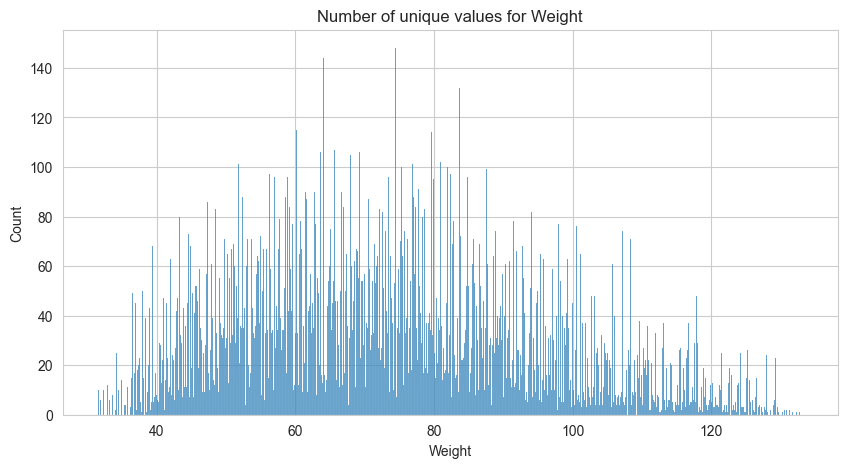

col: Weight     min: 31.5     max: 133.1


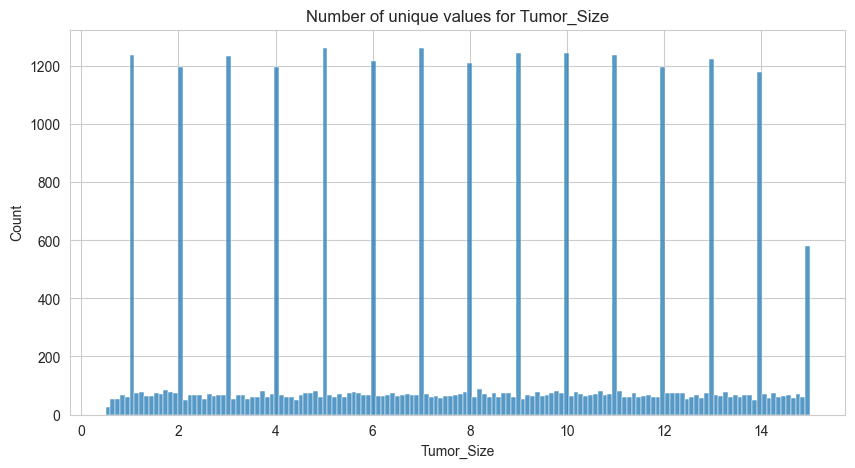

col: Tumor_Size     min: 0.5     max: 15.0


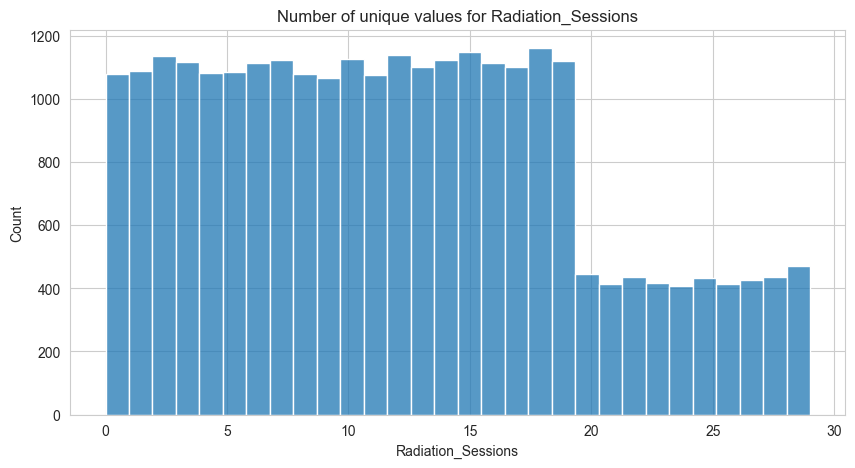

col: Radiation_Sessions     min: 0     max: 29


In [119]:
selected_columns = [2, 12, 15]

for col_index in selected_columns:
    col = train_df.columns[col_index]
    plt.figure(figsize=(10, 5))
    sns.histplot(train_df[col], bins=len(train_df[col].unique()))
    plt.title(f'Number of unique values for {col}')
    plt.show()
    print(f'col: {col}     min: {train_df[col].min()}     max: {train_df[col].max()}')


### 🔢 Manipulate Columns
In this subsection, we extract numerical values from columns.

| Transformation           | What it does                                                                                                                 | Resulting column                   |
| ------------------------ | ---------------------------------------------------------------------------------------------------------------------------- | ---------------------------------- |
| **Height** → float       | strips the `"cm"` suffix and casts to float                                                                                  | `Height_cm`                        |
| **Dates**                | parses every column that ends in `"Date"` to `datetime64` | the original column (over-written)                 |
| **Stage\_at\_Diagnosis** | converts the Roman-numeral stage to an integer (I → 1,…, IV → 4 etc.)                                                        | `Stage_at_Diagnosis_int`           |
| **Yes/No flags**         | columns that contain only *yes/no* values (case-insensitive) become 1/0 ints                                                 | the original column (over-written) |


In [120]:
def basic_clean(df: pd.DataFrame) -> pd.DataFrame:
    
    out = df.copy()

    if "Height" in out.columns:
        out["Height_cm"] = (
            out["Height"]
            .astype(str)
            .str.replace("cm", "", regex=False)
            .replace("", np.nan)
            .astype(float)
        )

    date_cols = [c for c in out.columns if "Date" in c]
    for col in date_cols:
        out[col] = pd.to_datetime(out[col], errors="coerce")

    roman_map = {"0": 0, "I": 1, "II": 2, "III": 3, "IV": 4, "V": 5}
    if "Stage_at_Diagnosis" in out.columns:
        def roman_to_int(x):
            if pd.isna(x):
                return np.nan
            x = str(x).upper().strip()
            return roman_map.get(x, np.nan)

        out["Stage_at_Diagnosis_int"] = out["Stage_at_Diagnosis"].apply(roman_to_int)

    yes_pattern = re.compile(r"^(yes|no|y|n)$", flags=re.I)
    for col in out.columns:
        unique_vals = out[col].dropna().astype(str).str.strip().unique()
        if len(unique_vals) <= 2 and all(bool(yes_pattern.match(v)) for v in unique_vals):
            out[col] = (
                out[col]
                .astype(str)
                .str.strip()
                .str.lower()                       
                .map({"yes": 1, "y": 1, "no": 0, "n": 0})
                .astype("Int8")
            )

    return out


train_df = basic_clean(train_df)
test_df  = basic_clean(test_df)

print("After clean-up:")
print(train_df[["Height_cm", "Birth_Date", "Stage_at_Diagnosis_int", "Family_History"]].head())

After clean-up:
   Height_cm Birth_Date  Stage_at_Diagnosis_int  Family_History
0      155.0 1994-07-01                       2               0
1      171.0 1992-07-16                       1               1
2      170.0 1948-06-23                       4               0
3      171.0 1954-11-26                       4               1
4      186.0 1979-07-08                       2               1


### ➕ Additional Columns  
In this subsection, we add some additional columns to the dataframe.

In [121]:
DROP_COLS = [
    "id",
    "Birth_Date", "Diagnosis_Date", "Surgery_Date",
    "Height",
    "Stage_at_Diagnosis"
]

def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # Age at diagnosis
    if {"Birth_Date", "Diagnosis_Date"}.issubset(out.columns):
        age_years = (out["Diagnosis_Date"] - out["Birth_Date"]).dt.days // 365
        out["Age_at_Diagnosis"] = age_years.astype("Int16", errors="ignore")

    # Surgery lag (days)
    if {"Surgery_Date", "Diagnosis_Date"}.issubset(out.columns):
        lag_days = (out["Surgery_Date"] - out["Diagnosis_Date"]).dt.days
        lag_days = lag_days.mask(lag_days < 0)
        out["Time_to_Surgery_days"] = lag_days.astype("Int16", errors="ignore")

    # BMI
    if {"Weight", "Height_cm"}.issubset(out.columns):
        h_m = out["Height_cm"] / 100
        bmi = out["Weight"].astype(float) / (h_m.pow(2))
        out["BMI"] = bmi.replace([np.inf, -np.inf], np.nan)

    # Chemo drug count
    if "Chemotherapy_Drugs" in out.columns:
        out["Chemo_Drug_Count"] = (
            out["Chemotherapy_Drugs"]
            .where(out["Chemotherapy_Drugs"].notna())
            .astype(str)
            .str.split("+")
            .str.len()
        ).astype("Int8", errors="ignore")

    # Radiation flag
    if "Radiation_Sessions" in out.columns:
        sessions = pd.to_numeric(out["Radiation_Sessions"], errors="coerce")
        out["Radiation_Flag"] = (sessions > 0).astype("Int8")

    # Year / month of diagnosis
    if "Diagnosis_Date" in out.columns:
        out["Diagnosis_Year"]  = out["Diagnosis_Date"].dt.year.astype("Int16", errors="ignore")
        out["Diagnosis_Month"] = out["Diagnosis_Date"].dt.month.astype("Int8",  errors="ignore")

    # Stage × Age interaction
    if {"Stage_at_Diagnosis_int", "Age_at_Diagnosis"}.issubset(out.columns):
        out["Stage_x_Age"] = out["Stage_at_Diagnosis_int"] * out["Age_at_Diagnosis"]

    # Tumour size binning
    if "Tumor_Size" in out.columns:
        size_bins = [0, 2, 5, 10, 50, np.inf]
        out["Tumor_Size_Bin"] = pd.cut(
            out["Tumor_Size"].astype(float),
            bins=size_bins, labels=False, include_lowest=True
        ).astype("Int8", errors="ignore")

    # final clean up
    out.drop(columns=[c for c in DROP_COLS if c in out.columns], inplace=True)

    return out


train_df = engineer_features(train_df)
test_df  = engineer_features(test_df)

print("Final feature set:", train_df.shape[1], "columns")

Final feature set: 27 columns


In [122]:
display(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26473 entries, 0 to 26472
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Weight                  26473 non-null  float64
 1   Urban_Rural             26473 non-null  object 
 2   Occupation              26473 non-null  object 
 3   Insurance_Type          26473 non-null  object 
 4   Family_History          26473 non-null  Int8   
 5   Cancer_Type             26473 non-null  object 
 6   Symptoms                25972 non-null  object 
 7   Tumor_Size              26473 non-null  float64
 8   Chemotherapy_Drugs      22423 non-null  object 
 9   Radiation_Sessions      26473 non-null  int64  
 10  Immunotherapy           26473 non-null  Int8   
 11  Targeted_Therapy        26473 non-null  Int8   
 12  Recurrence_Status       26473 non-null  Int8   
 13  Smoking_History         26473 non-null  object 
 14  Alcohol_Use             26473 non-null

None

### 🛠 Handling Missing Values 💡
There are several ways to handle missing numerical values in a dataset, some of which include:

- ``Deleting rows with missing values`` : This approach simply removes any rows that contain missing values, but it can be problematic if a large portion of the dataset contains missing values.

- ``Imputing with mean or median`` : This method involves replacing the missing values with the mean or median of the existing values in that column. This approach can work well if the distribution of the data is normal, but it may not be suitable for skewed data.

- ``Imputing with regression`` : This method involves using a regression model to predict the missing values based on other variables in the dataset. This approach can work well if there is a strong correlation between the missing value and other variables in the dataset.

- ``Using a clustering algorithm`` : This method involves using clustering algorithms to group similar data points together and then imputing the missing values with the mean or median value of the cluster. This approach can work well if there is a clear clustering structure in the data.

- ``Using the K-Nearest Neighbors algorithm``: This method involves finding the K nearest neighbors of the missing value and imputing the missing value with the average of the K nearest neighbors. This approach can work well if there is a strong correlation between the missing value and its nearest neighbors.

The choice of method depends on the nature of the missing data and the analysis goals.

#### Detect Missing Values

In [123]:
print(train_df.isnull().sum())

Weight                        0
Urban_Rural                   0
Occupation                    0
Insurance_Type                0
Family_History                0
Cancer_Type                   0
Symptoms                    501
Tumor_Size                    0
Chemotherapy_Drugs         4050
Radiation_Sessions            0
Immunotherapy                 0
Targeted_Therapy              0
Recurrence_Status             0
Smoking_History               0
Alcohol_Use                   0
label                         0
Height_cm                     0
Stage_at_Diagnosis_int        0
Age_at_Diagnosis             87
Time_to_Surgery_days      12258
BMI                           0
Chemo_Drug_Count              0
Radiation_Flag                0
Diagnosis_Year                0
Diagnosis_Month               0
Stage_x_Age                  87
Tumor_Size_Bin                0
dtype: int64


#### virtualization of Missing Values

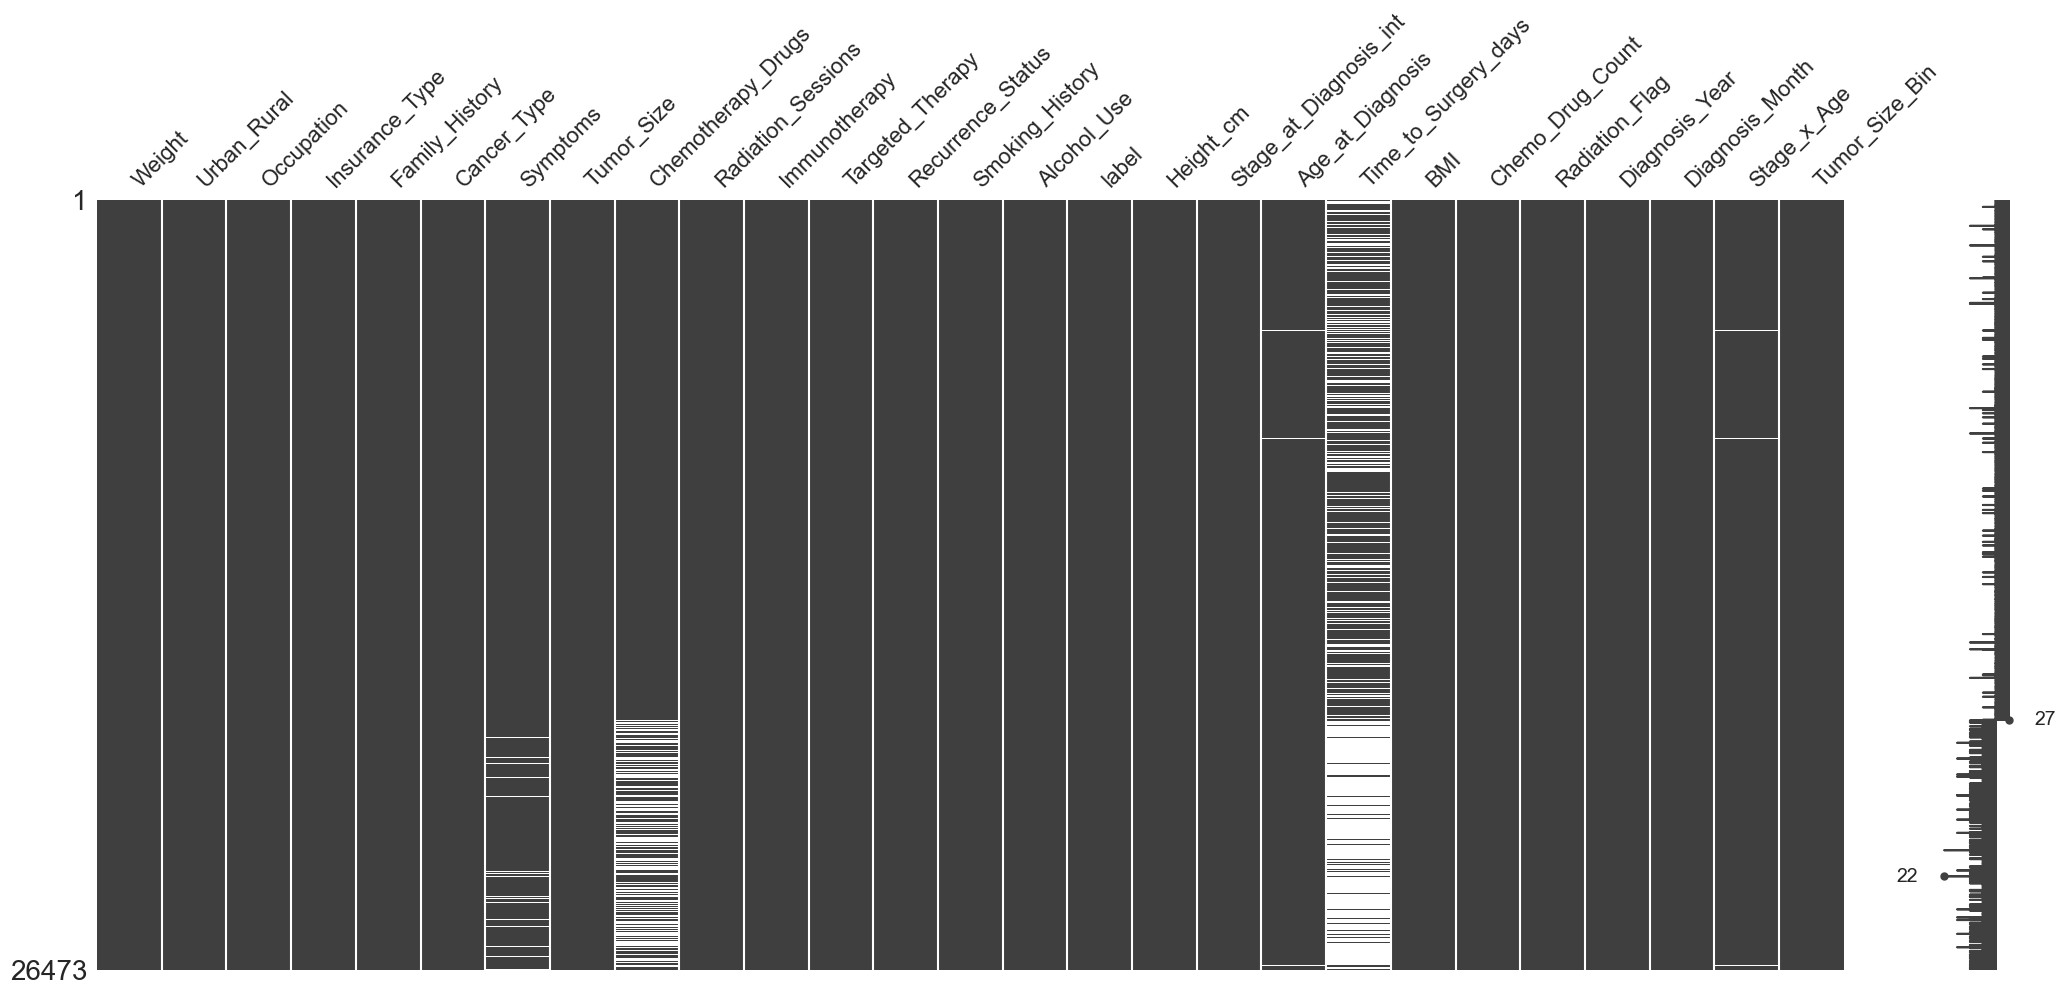

In [124]:
msno.matrix(train_df)
plt.show()

In [125]:
def handle_missing(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    # 1) Age_at_Diagnosis – median imputation
    if "Age_at_Diagnosis" in out.columns:
        age_imp  = SimpleImputer(strategy="median")
        age_vals = age_imp.fit_transform(out[["Age_at_Diagnosis"]]).ravel()
        out["Age_at_Diagnosis"] = age_vals.astype("int16")

    # 2) Recompute Stage_x_Age
    if {"Stage_at_Diagnosis_int", "Age_at_Diagnosis"}.issubset(out.columns):
        out["Stage_x_Age"] = out["Stage_at_Diagnosis_int"] * out["Age_at_Diagnosis"]

    # 3) Surgery flag
    if "Time_to_Surgery_days" in out.columns:
        out["Surgery_Done_Flag"] = (~out["Time_to_Surgery_days"].isna()).astype("int8")

    # 4) Chemo count NaN -> 0 + flag
    if "Chemo_Drug_Count" in out.columns:
        out["Chemo_Received_Flag"] = (out["Chemo_Drug_Count"] > 0).astype("int8")
        out["Chemo_Drug_Count"] = out["Chemo_Drug_Count"].fillna(0).astype("int8")

    return out


train_df = handle_missing(train_df)
test_df  = handle_missing(test_df)

print("Nulls after imputation (top 10):")
display(train_df.isna().sum().sort_values(ascending=False).head(10))


Nulls after imputation (top 10):


Time_to_Surgery_days    12258
Chemotherapy_Drugs       4050
Symptoms                  501
Weight                      0
Height_cm                   0
Surgery_Done_Flag           0
Tumor_Size_Bin              0
Stage_x_Age                 0
Diagnosis_Month             0
Diagnosis_Year              0
dtype: int64

## 📊 Data Visualization  
In this section, we create visual representations of the data to identify patterns, trends, and insights for better understanding and analysis🎯.

### Correlation Heatmap

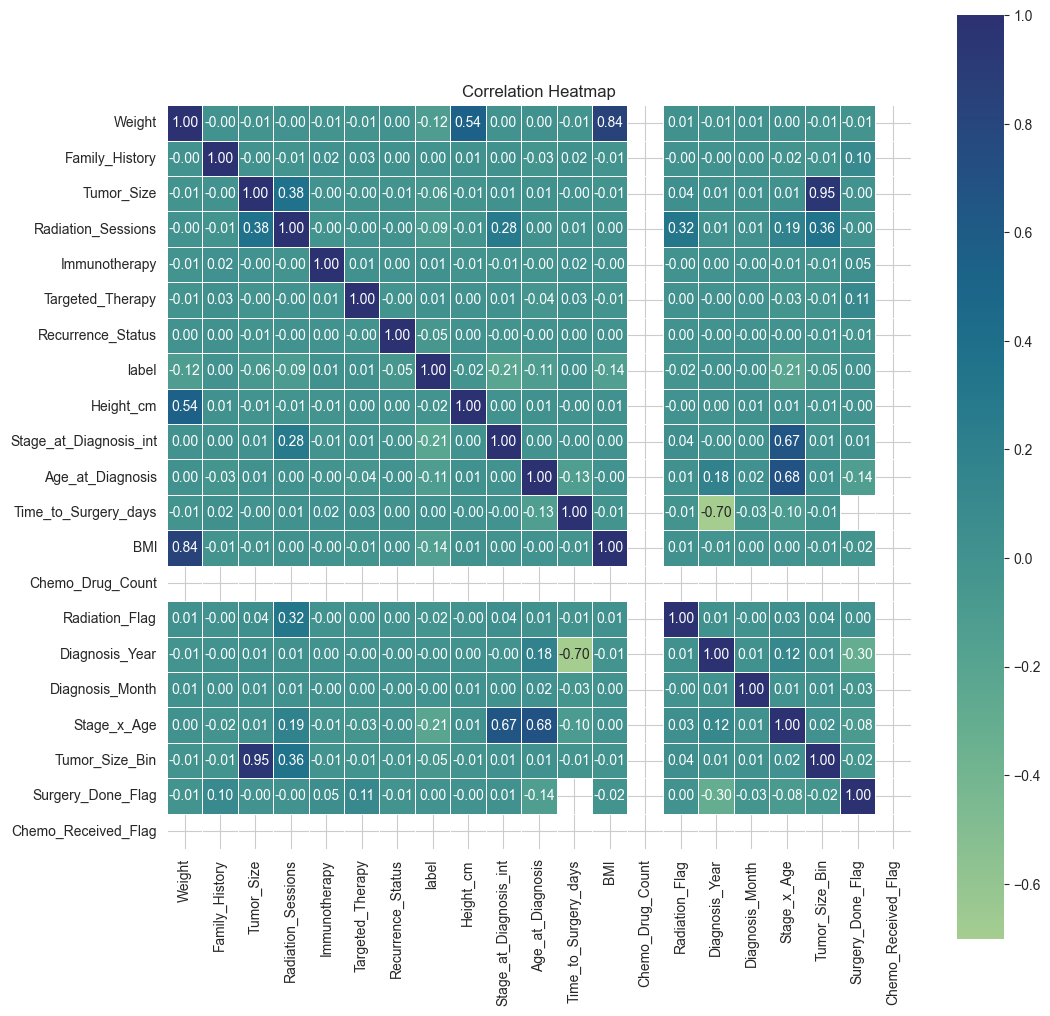

In [28]:
correlation_matrix = train_df.corr(method='pearson', numeric_only=True)

sns.set_style('whitegrid')
color_map = sns.color_palette("crest", as_cmap=True)
plt.figure(figsize=(12, 12))
sns.heatmap(
    correlation_matrix, 
    annot=True,
    fmt='.2f', 
    linewidths=0.5, 
    cbar=True, 
    cmap=color_map, 
    square=True
)
plt.title("Correlation Heatmap")
plt.show()

## 🚀 Model Development  󠀹󠀹󠀹󠁿

### CatBoost randomised search with 5-fold CV

In [37]:
#{'one_hot_max_size': 6, 'learning_rate': 0.06, 'l2_leaf_reg': 1, 'depth': 5, 'border_count': 254, 'bagging_temperature': 0.3333333333333333}

X = X_full
y = y_full

RANDOM_SEED = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

param_dist = {
    "depth":           list(range(5, 10)),
    "learning_rate":   np.linspace(0.03, 0.15, 5),
    "l2_leaf_reg":     list(range(1, 11, 2)),
    "bagging_temperature": np.linspace(0, 1, 4),
    "border_count":    [128, 254],
    "one_hot_max_size": [2, 4, 6],
}

n_iter = 25       
best_score, best_params = 0, None

for i, params in enumerate(ParameterSampler(param_dist, n_iter, random_state=RANDOM_SEED), 1):
    fold_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

        for c in cat_cols:
            X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
            X_va[c] = X_va[c].astype("string").fillna("__NA__")

        pool_tr = Pool(X_tr, y_tr, cat_features=cat_cols)
        pool_va = Pool(X_va, y_va, cat_features=cat_cols)

        model = CatBoostClassifier(
            iterations=1500,
            early_stopping_rounds=100,
            loss_function="Logloss",
            eval_metric="Accuracy",
            random_seed=RANDOM_SEED,
            verbose=False,
            **params
        ).fit(pool_tr, eval_set=pool_va, use_best_model=True)

        fold_scores.append(model.get_best_score()["validation"]["Accuracy"])

    mean_acc = np.mean(fold_scores)
    print(f"[{i}/{n_iter}] mean CV acc = {mean_acc:.4f}  params = {params}")

    if mean_acc > best_score:
        best_score, best_params = mean_acc, params

print("\nBest CV accuracy:", round(best_score, 4))
pprint.pprint(best_params)


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[1/25] mean CV acc = 0.8206  params = {'one_hot_max_size': 6, 'learning_rate': 0.06, 'l2_leaf_reg': 5, 'depth': 6, 'border_count': 128, 'bagging_temperature': 0.3333333333333333}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[2/25] mean CV acc = 0.8200  params = {'one_hot_max_size': 4, 'learning_rate': 0.06, 'l2_leaf_reg': 3, 'depth': 7, 'border_count': 254, 'bagging_temperature': 0.3333333333333333}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[3/25] mean CV acc = 0.8207  params = {'one_hot_max_size': 6, 'learning_rate': 0.06, 'l2_leaf_reg': 1, 'depth': 5, 'border_count': 254, 'bagging_temperature': 0.3333333333333333}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[4/25] mean CV acc = 0.8188  params = {'one_hot_max_size': 2, 'learning_rate': 0.03, 'l2_leaf_reg': 7, 'depth': 9, 'border_count': 128, 'bagging_temperature': 0.3333333333333333}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[5/25] mean CV acc = 0.8205  params = {'one_hot_max_size': 2, 'learning_rate': 0.06, 'l2_leaf_reg': 9, 'depth': 6, 'border_count': 128, 'bagging_temperature': 0.6666666666666666}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[6/25] mean CV acc = 0.8195  params = {'one_hot_max_size': 2, 'learning_rate': 0.12, 'l2_leaf_reg': 9, 'depth': 8, 'border_count': 254, 'bagging_temperature': 0.6666666666666666}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[7/25] mean CV acc = 0.8199  params = {'one_hot_max_size': 4, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'depth': 6, 'border_count': 254, 'bagging_temperature': 0.0}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[8/25] mean CV acc = 0.8199  params = {'one_hot_max_size': 6, 'learning_rate': 0.09, 'l2_leaf_reg': 5, 'depth': 6, 'border_count': 254, 'bagging_temperature': 0.3333333333333333}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[9/25] mean CV acc = 0.8191  params = {'one_hot_max_size': 2, 'learning_rate': 0.03, 'l2_leaf_reg': 5, 'depth': 9, 'border_count': 128, 'bagging_temperature': 0.0}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[10/25] mean CV acc = 0.8188  params = {'one_hot_max_size': 2, 'learning_rate': 0.15, 'l2_leaf_reg': 7, 'depth': 9, 'border_count': 254, 'bagging_temperature': 0.3333333333333333}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[11/25] mean CV acc = 0.8189  params = {'one_hot_max_size': 6, 'learning_rate': 0.06, 'l2_leaf_reg': 5, 'depth': 8, 'border_count': 254, 'bagging_temperature': 0.6666666666666666}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[12/25] mean CV acc = 0.8195  params = {'one_hot_max_size': 2, 'learning_rate': 0.12, 'l2_leaf_reg': 9, 'depth': 8, 'border_count': 254, 'bagging_temperature': 1.0}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[13/25] mean CV acc = 0.8203  params = {'one_hot_max_size': 4, 'learning_rate': 0.12, 'l2_leaf_reg': 7, 'depth': 6, 'border_count': 128, 'bagging_temperature': 0.0}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[14/25] mean CV acc = 0.8201  params = {'one_hot_max_size': 6, 'learning_rate': 0.06, 'l2_leaf_reg': 5, 'depth': 7, 'border_count': 128, 'bagging_temperature': 0.6666666666666666}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[15/25] mean CV acc = 0.8196  params = {'one_hot_max_size': 4, 'learning_rate': 0.06, 'l2_leaf_reg': 3, 'depth': 5, 'border_count': 128, 'bagging_temperature': 0.3333333333333333}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[16/25] mean CV acc = 0.8206  params = {'one_hot_max_size': 2, 'learning_rate': 0.09, 'l2_leaf_reg': 9, 'depth': 6, 'border_count': 128, 'bagging_temperature': 1.0}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[17/25] mean CV acc = 0.8182  params = {'one_hot_max_size': 2, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'depth': 5, 'border_count': 128, 'bagging_temperature': 0.6666666666666666}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[18/25] mean CV acc = 0.8202  params = {'one_hot_max_size': 2, 'learning_rate': 0.06, 'l2_leaf_reg': 1, 'depth': 8, 'border_count': 254, 'bagging_temperature': 1.0}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[19/25] mean CV acc = 0.8194  params = {'one_hot_max_size': 2, 'learning_rate': 0.06, 'l2_leaf_reg': 5, 'depth': 7, 'border_count': 128, 'bagging_temperature': 1.0}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[20/25] mean CV acc = 0.8196  params = {'one_hot_max_size': 2, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'depth': 6, 'border_count': 254, 'bagging_temperature': 0.3333333333333333}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[21/25] mean CV acc = 0.8203  params = {'one_hot_max_size': 4, 'learning_rate': 0.12, 'l2_leaf_reg': 7, 'depth': 7, 'border_count': 128, 'bagging_temperature': 0.3333333333333333}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[22/25] mean CV acc = 0.8200  params = {'one_hot_max_size': 6, 'learning_rate': 0.15, 'l2_leaf_reg': 9, 'depth': 5, 'border_count': 128, 'bagging_temperature': 1.0}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[23/25] mean CV acc = 0.8192  params = {'one_hot_max_size': 6, 'learning_rate': 0.15, 'l2_leaf_reg': 7, 'depth': 5, 'border_count': 254, 'bagging_temperature': 0.3333333333333333}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[24/25] mean CV acc = 0.8193  params = {'one_hot_max_size': 2, 'learning_rate': 0.12, 'l2_leaf_reg': 1, 'depth': 6, 'border_count': 254, 'bagging_temperature': 0.0}


C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[c] = X_tr[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_va[c] = X_va[c].astype("string").fillna("__NA__")
C:\Users\Amir\AppData\Local\Temp\ipykernel_16260\4245196072.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

[25/25] mean CV acc = 0.8201  params = {'one_hot_max_size': 2, 'learning_rate': 0.09, 'l2_leaf_reg': 3, 'depth': 5, 'border_count': 128, 'bagging_temperature': 0.0}

Best CV accuracy: 0.8207
{'bagging_temperature': 0.3333333333333333,
 'border_count': 254,
 'depth': 5,
 'l2_leaf_reg': 1,
 'learning_rate': 0.06,
 'one_hot_max_size': 6}


In [ ]:
X = X_full.copy()
y = y_full.copy()

# Pre-transform categorical columns outside the loop
cat_cols = [c for c in X.columns if X[c].dtype == "string"]
for c in cat_cols:
    X[c] = X[c].astype("string").fillna("__NA__")

RANDOM_SEED = 42
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

param_dist = {
    "depth": list(range(5, 10)),
    "learning_rate": np.linspace(0.03, 0.15, 5),
    "l2_leaf_reg": list(range(1, 11, 2)),
    "bagging_temperature": np.linspace(0, 1, 4),
    "border_count": [128, 254],
    "one_hot_max_size": [2, 4, 6],
    "iterations": [500, 1000, 1500],
}

n_iter = 25
best_score, best_params = 0, None

for i, params in enumerate(ParameterSampler(param_dist, n_iter, random_state=RANDOM_SEED), 1):
    fold_scores = []
    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

        pool_tr = Pool(X_tr, y_tr, cat_features=cat_cols)
        pool_va = Pool(X_va, y_va, cat_features=cat_cols)

        model = CatBoostClassifier(
            early_stopping_rounds=100,
            loss_function="Logloss",
            eval_metric="Accuracy",
            random_seed=RANDOM_SEED,
            verbose=False,
            **params
        ).fit(pool_tr, eval_set=pool_va, use_best_model=True)

        fold_scores.append(model.get_best_score()["validation"]["Accuracy"])

    mean_acc = np.mean(fold_scores)
    print(f"[{i}/{n_iter}] mean CV acc = {mean_acc:.4f}  params = {params}")

    if mean_acc > best_score:
        best_score, best_params = mean_acc, params

print("\nBest CV accuracy:", round(best_score, 4))
pprint.pprint(best_params)

[1/25] mean CV acc = 0.8199  params = {'one_hot_max_size': 4, 'learning_rate': 0.12, 'l2_leaf_reg': 9, 'iterations': 500, 'depth': 7, 'border_count': 128, 'bagging_temperature': 1.0}
[2/25] mean CV acc = 0.8199  params = {'one_hot_max_size': 6, 'learning_rate': 0.06, 'l2_leaf_reg': 5, 'iterations': 1500, 'depth': 8, 'border_count': 128, 'bagging_temperature': 0.0}
[3/25] mean CV acc = 0.8197  params = {'one_hot_max_size': 6, 'learning_rate': 0.06, 'l2_leaf_reg': 9, 'iterations': 1500, 'depth': 8, 'border_count': 128, 'bagging_temperature': 0.6666666666666666}
[4/25] mean CV acc = 0.8189  params = {'one_hot_max_size': 4, 'learning_rate': 0.03, 'l2_leaf_reg': 3, 'iterations': 500, 'depth': 8, 'border_count': 128, 'bagging_temperature': 0.6666666666666666}
[5/25] mean CV acc = 0.8204  params = {'one_hot_max_size': 4, 'learning_rate': 0.06, 'l2_leaf_reg': 5, 'iterations': 1000, 'depth': 5, 'border_count': 254, 'bagging_temperature': 0.6666666666666666}
[6/25] mean CV acc = 0.8193  params =

### Train on full data & export submission CSV

In [144]:
TARGET = "label"

X_full = train_df.drop(columns=[TARGET]).copy()
y_full = train_df[TARGET].copy()

cat_cols = [c for c in X_full.columns if X_full[c].dtype == "object"]
for c in cat_cols:
    X_full[c]   = X_full[c].astype("string").fillna("__NA__")
    test_df[c]  = test_df[c].astype("string").fillna("__NA__")

full_pool = Pool(X_full, y_full, cat_features=cat_cols)
test_pool = Pool(test_df, cat_features=cat_cols)

best_params = {
    "iterations": 600,
    "depth": 7,
    "learning_rate": 0.06,
    "l2_leaf_reg": 1,
    "bagging_temperature": 0.3,
    "one_hot_max_size": 6,
    "loss_function": "Logloss",
    "eval_metric": "Accuracy",
    "random_seed": 42,
    "verbose": False
}

final_model = CatBoostClassifier(**best_params)
final_model.fit(full_pool)

pred_labels = final_model.predict(test_pool).astype(int)

RAW_TEST_PATH = "test_data.csv"
try:
    test_ids = pd.read_csv(RAW_TEST_PATH, usecols=["id"])["id"]
except ValueError:
    test_ids = pd.Series(np.arange(1, len(test_df) + 1, dtype=int), name="id")

submission = pd.DataFrame({
    "id": test_ids,
    "label": pred_labels
})

csv_path = "task1_submission.csv"
submission.to_csv(csv_path, index=False)

### 🧪 Analyzing Model Performance

1. **Confusion Matrix** :

   Displays the true positive, false positive, true negative, and false negative counts for each class.

2. **Accuracy** : 

   The ratio of correctly predicted samples to the total samples.

3. **Precision, Recall, and F1-Score** :

   - Calculated for each class and averages.

   - `Precision`: $\frac{\text{True Positives}}{\text{True Positives } + \text{ False Positives}}$

   - `Recall`: $\frac{\text{True Positives}}{\text{True Positives} + \text{ False Negatives}}$

   - `F1-Score`: Harmonic mean of precision and recall.


In [145]:
X = X_full
y = y_full

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

y_pred = final_model.predict(X_val)

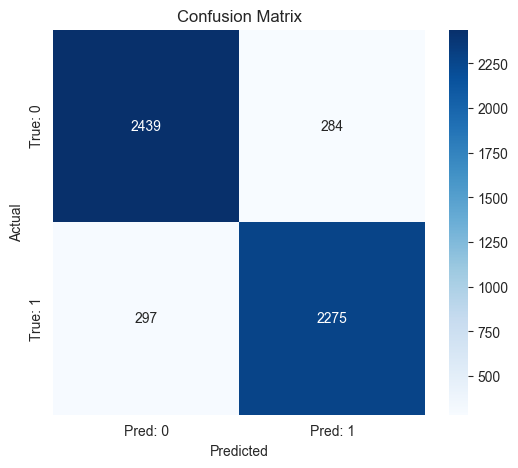

In [146]:
conf_matrix = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=["Pred: 0", "Pred: 1"], yticklabels=["True: 0", "True: 1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [147]:
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8903


In [148]:
precision, recall, f1, _ = precision_recall_fscore_support(y_val, y_pred, average=None)

print("\nPrecision, Recall, F1-Score for each class:")
print(f"Class 0 - Precision: {precision[0]:.4f}, Recall: {recall[0]:.4f}, F1-Score: {f1[0]:.4f}")
print(f"Class 1 - Precision: {precision[1]:.4f}, Recall: {recall[1]:.4f}, F1-Score: {f1[1]:.4f}")

# --- 4. Macro-averaged Precision, Recall, F1-Score ---
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(y_val, y_pred, average='macro')
print(f"\nMacro-averaged - Precision: {precision_macro:.4f}, Recall: {recall_macro:.4f}, F1-Score: {f1_macro:.4f}")


Precision, Recall, F1-Score for each class:
Class 0 - Precision: 0.8914, Recall: 0.8957, F1-Score: 0.8936
Class 1 - Precision: 0.8890, Recall: 0.8845, F1-Score: 0.8868

Macro-averaged - Precision: 0.8902, Recall: 0.8901, F1-Score: 0.8902
